In [6]:
import pretty_midi 
import numpy as np
import pandas as pd
import collections
import matplotlib.pyplot as plt
from typing import Optional
import os
import tensorflow as tf
from IPython import display

In [7]:
audio_data = 'midi/Carlevaro_Introduccion.mid'

In [8]:
midi_data = pretty_midi.PrettyMIDI(audio_data)

In [9]:
print(midi_data.estimate_tempo())

171.85459303276724


In [10]:
total_velocity = sum(sum(midi_data.get_chroma()))
print ([sum(semitone)/total_velocity for semitone in midi_data.get_chroma()])
# Shift all notes up by 5 semitones
for instrument in midi_data.instruments:
    # Don't want to shift drum notes
    if not instrument.is_drum:
        for note in instrument.notes:
            note.pitch += 5
# Synthesize the resulting MIDI data using sine waves
audio_data = midi_data.synthesize()

[0.0645552094150225, 0.06910828873445696, 0.05800516548180099, 0.07806800330164816, 0.17647841946907367, 0.053891418377399684, 0.08178235748329206, 0.07764198418404025, 0.09699922784034934, 0.0715312724658519, 0.04310780946294965, 0.1288308437841148]


In [11]:
print('Number of instruments:', len(midi_data.instruments))
instrument = midi_data.instruments
instrument_name = list()
for i in instrument:
    instrument_name.append(pretty_midi.program_to_instrument_name(i.program))
print('Instrument name:', instrument_name)


Number of instruments: 3
Instrument name: ['Acoustic Guitar (nylon)', 'Acoustic Guitar (nylon)', 'Woodblock']


In [12]:
# for i, note in enumerate(instrument.notes):
#   note_name = pretty_midi.note_number_to_name(note.pitch)
#   duration = note.end - note.start
#   print(f'{i}: pitch={note.pitch}, note_name={note_name},'
#         f' duration={duration:.4f}')


In [13]:
def midi_to_notes(midi_file: str) -> pd.DataFrame:
    pm = pretty_midi.PrettyMIDI(midi_file)
    instrument = pm.instruments[0]
    notes = collections.defaultdict(list)

    sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
    prev_start = sorted_notes[0].start

    for note in sorted_notes:
        start = note.start
        end = note.end
        notes['pitch'].append(note.pitch)
        notes['start'].append(start)
        notes['end'].append(end)
        notes['step'].append(start - prev_start)
        notes['duration'].append(end - start)
        prev_start = start
    return pd.DataFrame({name: np.array(value) for name, value in notes.items()})
    

In [14]:
raw_notes = midi_to_notes('midi/Carlevaro_Introduccion.mid')
raw_notes.head(10)

,pitch,start,end,step,duration
0,64,0.0,0.6,0.0,0.6
1,61,0.6,0.9,0.6,0.3
2,62,0.9,1.5,0.3,0.6
3,61,1.5,2.1,0.6,0.6
4,64,2.1,2.4,0.6,0.3
5,62,2.4,3.0,0.3,0.6
6,61,3.0,4.5,0.6,1.5
7,64,4.8,5.4,1.8,0.6
8,67,5.4,5.7,0.6,0.3
9,66,5.7,6.3,0.3,0.6


In [15]:
get_note_names = np.vectorize(pretty_midi.note_number_to_name)
sample_note_names = get_note_names(raw_notes['pitch'])
sample_note_names

array(['E4', 'C#4', 'D4', 'C#4', 'E4', 'D4', 'C#4', 'E4', 'G4', 'F#4',
       'E4', 'A4', 'G#4', 'A4', 'E4', 'G4', 'F#4', 'E4', 'A4', 'G#4',
       'A4', 'C5', 'C5', 'A#4', 'G#4', 'B3', 'F#4', 'E2', 'E4', 'G#3',
       'G4', 'B3', 'F#4', 'E4', 'A#3', 'G#4', 'A3', 'F#4', 'D4', 'E4',
       'B4', 'A#4', 'F#4', 'A4', 'G3', 'B3', 'G4', 'D3', 'G3', 'B3',
       'F#4', 'D#3', 'G3', 'B3', 'C4', 'D4', 'C4', 'D4', 'C#4', 'D#4',
       'E4', 'E4', 'D4', 'E4', 'G3', 'B3', 'E4', 'E4', 'D#4', 'E4', 'G3',
       'B3', 'E5', 'E5', 'D5', 'C5', 'A#4', 'C#4', 'E4', 'F#4', 'E4',
       'A#3', 'E4', 'G4', 'G4', 'F#4', 'E4', 'B3', 'E4', 'B3', 'E4', 'B3',
       'E4', 'B3', 'E4', 'E4', 'C#4', 'D4', 'C#4', 'E4', 'D4', 'C#4',
       'E4', 'G4', 'F#4', 'E4', 'A4', 'G#4', 'G#4', 'A4', 'C5', 'B4',
       'A4', 'D#4', 'C#5', 'D4', 'B4', 'G4', 'A4', 'E5', 'D#5', 'B4',
       'D5', 'C4', 'E4', 'C5', 'G3', 'C4', 'E4', 'B4', 'F4', 'G4', 'F4',
       'G4', 'F#4', 'G#4', 'A4', 'A4', 'G4', 'A4', 'C4', 'E4', 'A4', 'A4',


In [16]:
def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):
  if count:
    title = f'First {count} notes'
  else:
    title = f'Whole track'
    count = len(notes['pitch'])
  plt.figure(figsize=(20, 4))
  plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
  plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
  plt.plot(
      plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
  plt.xlabel('Time [s]')
  plt.ylabel('Pitch')
  _ = plt.title(title)

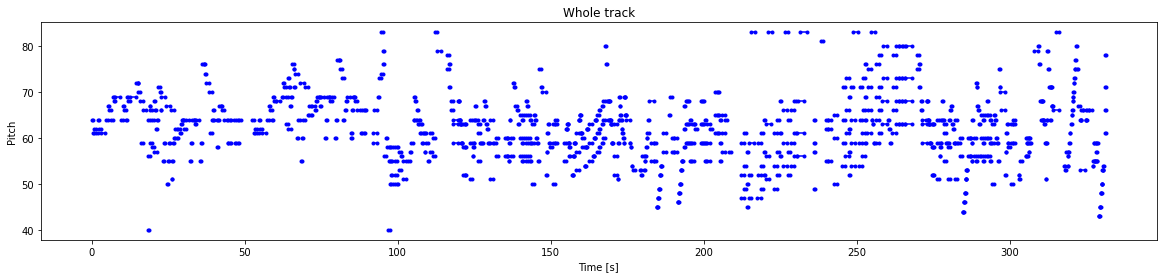

In [17]:
plot_piano_roll(raw_notes)


In [122]:
midi_directory = 'midi/'
filenames = sorted(os.listdir(midi_directory))
len(filenames)

59

In [123]:
num_files = 40
all_notes = []
for f in filenames[:num_files]:
    notes = midi_to_notes(midi_directory + f)
    all_notes.append(notes)

all_notes = pd.concat(all_notes)
# all_notes = np.array(all_notes)
# all_notes.shape

c:\Users\detam\AppData\Local\Programs\Python\Python310\lib\site-packages\pretty_midi\pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


In [124]:
all_notes.shape

(36382, 5)

In [138]:
n = all_notes.shape[0] - 2
i = 1
a = []
while i ** 2 <= n:
    if n % i == 0:
        a.append(i)
        if i != n // i:
            a.append(n // i)
    i += 1
a.sort()
print(a)

[1, 2, 4, 5, 10, 17, 20, 34, 68, 85, 107, 170, 214, 340, 428, 535, 1070, 1819, 2140, 3638, 7276, 9095, 18190, 36380]


In [141]:
print((all_notes.shape[0]-2) // 17)

2140


In [139]:
all_notes = np.array(all_notes)

In [142]:
all_notes = all_notes[:all_notes.shape[0]-2, :].reshape((2140, 17, 5))

In [143]:
all_notes

array([[[6.20000000e+01, 2.30769000e-01, 4.61538000e-01, 0.00000000e+00,
         2.30769000e-01],
        [6.60000000e+01, 4.61538000e-01, 6.92307000e-01, 2.30769000e-01,
         2.30769000e-01],
        [7.20000000e+01, 6.92307000e-01, 9.23076000e-01, 2.30769000e-01,
         2.30769000e-01],
        ...,
        [6.70000000e+01, 3.46153500e+00, 3.69230400e+00, 2.30769000e-01,
         2.30769000e-01],
        [6.50000000e+01, 3.69230400e+00, 3.92307300e+00, 2.30769000e-01,
         2.30769000e-01],
        [5.60000000e+01, 3.92307300e+00, 4.15384200e+00, 2.30769000e-01,
         2.30769000e-01]],

       [[5.90000000e+01, 4.15384200e+00, 4.38461100e+00, 2.30769000e-01,
         2.30769000e-01],
        [6.50000000e+01, 4.38461100e+00, 4.61538000e+00, 2.30769000e-01,
         2.30769000e-01],
        [6.40000000e+01, 4.61538000e+00, 4.84614900e+00, 2.30769000e-01,
         2.30769000e-01],
        ...,
        [6.60000000e+01, 8.36537700e+00, 8.59614600e+00, 2.30769000e-01,
        

In [144]:
input_notes = all_notes / np.array([128, 1, 1, 1, 1]) 

In [145]:
input_notes.shape

(2140, 17, 5)

In [146]:
input_notes_2 = input_notes[:,:,[0,3,4]]

In [147]:
input_notes_2.shape

(2140, 17, 3)

In [169]:
x_train, x_test = input_notes_2[:1712, :, :], input_notes_2[1712:, :, :]

In [28]:
#key_order = ['pitch', 'step', 'duration']
#train_notes = np.stack([all_notes[key] for key in key_order], axis=1)

In [29]:
# seq_length = 50
# vocab_size = 128
# embedding_dim = 256
# latent_dim = 50

#seq_ds = create_sequences(notes_ds, seq_length, vocab_size)
#seq_ds.element_spec

In [30]:
# for seq, target in seq_ds.take(1):
#   print('sequence shape:', seq.shape)
#   print('sequence elements (first 10):', seq[0: 10])
#   print()
#   print('target:', target)

In [31]:
# batch_size = 64
# buffer_size = n_notes - seq_length  # the number of items in the dataset
# train_ds = (seq_ds
#             .shuffle(buffer_size)
#             .batch(batch_size, drop_remainder=True)
#             .cache()
#             .prefetch(tf.data.experimental.AUTOTUNE))

In [32]:
#train_ds.element_spec

In [33]:
#for elem in train_ds.take(1):
# print('sequence elements (first 10):', elem)

In [34]:
# latent_dim = 1000
# input_shape = (12, 5)

# encoder_input = tf.keras.layers.Input(shape=input_shape)
# encoder_rnn = tf.keras.layers.LSTM(units=128, return_sequences=True)(encoder_input)
# encoder_rnn = tf.keras.layers.LSTM(units=64)(encoder_rnn)



# mu = tf.keras.layers.Dense(units=latent_dim, name='mu')(encoder_rnn)
# log_var = tf.keras.layers.Dense(units=latent_dim, name='log_var')(encoder_rnn)

# def noiser(args):
#     global mu, log_var
#     mu, log_var = args
#     Na = tf.keras.backend.random_normal(shape=(latent_dim,), mean=0.)
#     return tf.keras.backend.exp(log_var / 2) * Na + mu

# h = tf.keras.layers.Lambda(noiser, output_shape=(latent_dim,))([mu, log_var])

# decoder_inputs = tf.keras.layers.Input(shape=(latent_dim,))
# decoder_rnn = tf.keras.layers.RepeatVector(input_shape[0])(decoder_inputs)
# decoder_rnn = tf.keras.layers.LSTM(units=64, return_sequences=True)(decoder_rnn)
# output = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(units=input_shape[-1], activation='sigmoid'))(decoder_rnn)

# encoder = tf.keras.Model(encoder_input, h)
# decoder = tf.keras.Model(decoder_inputs, output)


In [191]:
import tensorflow.keras.backend as K
latent_dim = 16
inter_dim = 256
timesteps, features = input_notes_2.shape[1], 3
learning_rate = 0.00001
dropout = 0.1

In [36]:
def sampling(args):
    z_mean, z_log_sigma = args
    batch_size = tf.shape(z_mean)[0] # <================
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=1.)
    return z_mean + z_log_sigma * epsilon

In [192]:
inputs = tf.keras.layers.Input(shape=(timesteps, features))

#intemediate dimension
h = tf.keras.layers.LSTM(inter_dim//2, return_sequences=True, dropout=dropout)(inputs)
h = tf.keras.layers.LSTM(inter_dim//4, return_sequences=True)(h)
h = tf.keras.layers.LSTM(inter_dim, dropout=dropout)(h)

#z_layer
z_mean = tf.keras.layers.Dense(latent_dim)(h)
z_log_sigma = tf.keras.layers.Dense(latent_dim)(h)
z = tf.keras.layers.Lambda(sampling)([z_mean, z_log_sigma])

# decoder
decoder = tf.keras.layers.RepeatVector(timesteps)(z)
decoder = tf.keras.layers.LSTM(inter_dim, return_sequences=True)(decoder)
decoder = tf.keras.layers.LSTM(inter_dim//4, return_sequences=True)(decoder)
decoder = tf.keras.layers.LSTM(inter_dim//2, dropout=dropout, return_sequences=True)(decoder)
decoder = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(features))(decoder)

def vae_loss2(input_x, decoder1, z_log_sigma, z_mean):
    """ Calculate loss = reconstruction loss + KL loss for each data in minibatch """
    # E[log P(X|z)]
    recon = K.sum(K.binary_crossentropy(input_x, decoder1))
    # D_KL(Q(z|X) || P(z|X)); calculate in closed form as both dist. are Gaussian
    kl = 0.5 * K.sum(K.exp(z_log_sigma) + K.square(z_mean) - 1. - z_log_sigma)

    return recon + kl


In [193]:
model = tf.keras.Model(inputs, decoder)
model.add_loss(vae_loss2(inputs, decoder, z_log_sigma, z_mean))
model.compile(loss='huber', optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

In [194]:
model.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 17, 3)]      0           []                               
                                                                                                  
 lstm_78 (LSTM)                 (None, 17, 128)      67584       ['input_15[0][0]']               
                                                                                                  
 lstm_79 (LSTM)                 (None, 17, 64)       49408       ['lstm_78[0][0]']                
                                                                                                  
 lstm_80 (LSTM)                 (None, 256)          328704      ['lstm_79[0][0]']                
                                                                                           

In [195]:
input_notes_2.shape

(2140, 17, 3)

In [196]:
epochs = 10
history = model.fit(x_train, x_train, epochs=epochs, batch_size=5, use_multiprocessing=True, shuffle=False)

Epoch 1/10
343/343 [==============================] - 48s 111ms/step - loss: 497.2682
Epoch 2/10
343/343 [==============================] - 36s 105ms/step - loss: 329.4367
Epoch 3/10
343/343 [==============================] - 36s 105ms/step - loss: 235.6868
Epoch 4/10
343/343 [==============================] - 36s 104ms/step - loss: 221.3096
Epoch 5/10
343/343 [==============================] - 35s 101ms/step - loss: 211.1527
Epoch 6/10
343/343 [==============================] - 34s 100ms/step - loss: 201.2906
Epoch 7/10
343/343 [==============================] - 34s 98ms/step - loss: 194.8893
Epoch 8/10
343/343 [==============================] - 34s 98ms/step - loss: 191.4065
Epoch 9/10
343/343 [==============================] - 33s 98ms/step - loss: 188.6245
Epoch 10/10
343/343 [==============================] - 34s 99ms/step - loss: 185.5432


In [208]:
predictions = model.predict(x_test[0:5])

1/1 [==============================] - 0s 86ms/step


In [209]:
predictions[0]

array([[0.03374283, 0.01884745, 0.02553125],
       [0.09886123, 0.05479217, 0.07852104],
       [0.19358711, 0.1057182 , 0.15769814],
       [0.3023186 , 0.16279657, 0.25158134],
       [0.40638122, 0.21634705, 0.34525385],
       [0.491047  , 0.25922582, 0.4258882 ],
       [0.5489531 , 0.28812355, 0.4858974 ],
       [0.5796752 , 0.30306628, 0.5231732 ],
       [0.5872965 , 0.30616456, 0.53958714],
       [0.57780886, 0.30040717, 0.53910613],
       [0.5572535 , 0.28881723, 0.5262911 ],
       [0.5307385 , 0.27398968, 0.5053868 ],
       [0.50211334, 0.25791723, 0.47991017],
       [0.47401592, 0.24199404, 0.45255405],
       [0.44808337, 0.22710666, 0.42525268],
       [0.42519805, 0.21375118, 0.39930797],
       [0.40570977, 0.20214562, 0.3755242 ]], dtype=float32)

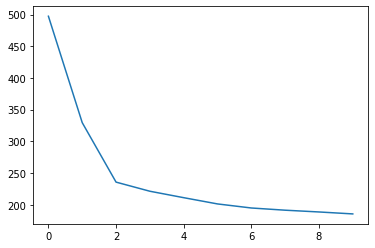

In [210]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()

In [44]:
def notes_to_midi(
  notes: pd.DataFrame,
  out_file: str, 
  instrument_name: str,
  velocity: int = 100,  # note loudness
) -> pretty_midi.PrettyMIDI:

  pm = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name))

  prev_start = 0
  for i, note in notes.iterrows():
    start = float(prev_start + note['step'])
    end = float(start + note['duration'])
    note = pretty_midi.Note(
        velocity=velocity,
        pitch=int(note['pitch']),
        start=start,
        end=end,
    )
    instrument.notes.append(note)
    prev_start = start

  pm.instruments.append(instrument)
  pm.write(out_file)
  return pm

In [211]:
generated_notes = pd.DataFrame(predictions[0:5].reshape(5*17, 3), columns=['pitch', 'step', 'duration'])
generated_notes.head()

,pitch,step,duration
0,0.033743,0.018847,0.025531
1,0.098861,0.054792,0.078521
2,0.193587,0.105718,0.157698
3,0.302319,0.162797,0.251581
4,0.406381,0.216347,0.345254


In [212]:
generated_notes['pitch'] = generated_notes['pitch'].apply(lambda x: round(x*128))
#generated_notes['step'] = generated_notes['step'].apply(lambda x: x*2)
print(generated_notes.head())
out_file = 'output.mid'
out_pm = notes_to_midi(
    generated_notes, out_file=out_file, instrument_name=instrument_name[0])

   pitch      step  duration
0      4  0.018847  0.025531
1     13  0.054792  0.078521
2     25  0.105718  0.157698
3     39  0.162797  0.251581
4     52  0.216347  0.345254


In [202]:
generated_notes

,pitch,step,duration
0,4,0.018949,0.025824
1,13,0.055159,0.079571
2,25,0.106502,0.159952
3,39,0.164075,0.255304
4,52,0.218108,0.350463
...,...,...,...
80,64,0.251100,0.467592
81,60,0.235160,0.440404
82,57,0.220188,0.413161
83,54,0.206703,0.387188


In [188]:
generated_notes_letters = np.vectorize(pretty_midi.note_number_to_name)

In [189]:
sample_note_names = get_note_names(generated_notes['pitch'])

In [190]:
sample_note_names

array(['C#4', 'G4', 'E4', 'F#4', 'F4', 'F#4', 'F#4', 'F#4', 'F#4', 'F#4',
       'F#4', 'F#4', 'F#4', 'F#4', 'F#4', 'F#4', 'F#4', 'C#4', 'F#4',
       'F4', 'F#4', 'F4', 'F#4', 'F#4', 'F#4', 'F#4', 'F#4', 'F#4', 'F#4',
       'F#4', 'F#4', 'F#4', 'F#4', 'F#4', 'D4', 'F#4', 'E4', 'F#4', 'F4',
       'F#4', 'F#4', 'F#4', 'F#4', 'F#4', 'F#4', 'F#4', 'F#4', 'F#4',
       'F#4', 'F#4', 'F#4', 'C#4', 'G4', 'F4', 'F#4', 'F4', 'F#4', 'F#4',
       'F#4', 'F#4', 'F#4', 'F#4', 'F#4', 'F#4', 'F#4', 'F#4', 'F#4',
       'F#4', 'D4', 'F#4', 'F4', 'F#4', 'F4', 'F#4', 'F#4', 'F#4', 'F#4',
       'F#4', 'F#4', 'F#4', 'F#4', 'F#4', 'F#4', 'F#4', 'F#4'],
      dtype='<U3')

In [229]:
import datetime
#print(str(datetime.datetime.now()))
try:
    model.save_weights(filepath='lstm_vae_weights')
    print('model saved succeed')
except Exception:
    print('не то')


model saved succeed


In [80]:
class LSTM_VAE(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, rnn_units, latent_dim, num_layers):
        super().__init__(self)

        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.rnn_units = rnn_units
        self.latent_dim = latent_dim
        self.num_layers = num_layers

        # Embedding layer
        self.embed = tf.keras.layers.Embedding(self.vocab_size, self.embedding_dim)

        # Encoder
        self.encoder_lstm = tf.keras.layers.LSTM(units=self.embedding_dim, )(self.embed)
